In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from alvra_tools.channels import *

In [3]:
scan_name ="jetscan_x_7150eV_2"


DIR = "/sf/alvra/data/p17589/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17589/res/scan_info/"

In [4]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 120G
-rw-r--r--.  1 17589 p17589 2.7G Jul  5 21:02 jetscan_x_7150eV_2_step0000.JF02T09V02.h5
-rw-r--r--.  1 17589 p17589 1.2G Jul  5 21:02 jetscan_x_7150eV_2_step0000.JF06T04V01.h5
-rw-r--r--.  1 root  p17589  24K Jul  5 21:02 jetscan_x_7150eV_2_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root  p17589  16K Jul  5 21:02 jetscan_x_7150eV_2_step0001.BSREAD_CA.h5
-rw-r--r--.  1 17589 p17589 2.7G Jul  5 21:02 jetscan_x_7150eV_2_step0001.JF02T09V02.h5
-rw-r--r--.  1 17589 p17589 1.2G Jul  5 21:02 jetscan_x_7150eV_2_step0001.JF06T04V01.h5
-rw-r--r--.  1 root  p17589  19K Jul  5 21:02 jetscan_x_7150eV_2_step0002.BSREAD_CA.h5
-rw-r--r--.  1 17589 p17589 2.7G Jul  5 21:03 jetscan_x_7150eV_2_step0002.JF02T09V02.h5
-rw-r--r--.  1 17589 p17589 1.2G Jul  5 21:03 jetscan_x_7150eV_2_step0002.JF06T04V01.h5
-rw-r--r--.  1 17589 p17589 2.7G Jul  5 21:03 jetscan_x_7150eV_2_step0003.JF02T09V02.h5
-rw-r--r--.  1 root  p17589  49M Jul  5 21:03 jetscan_x_7150eV_2_step0000.BSREAD.h5
-rw-r--r--.  1 17589 p17589 

ra-c-014.psi.ch
There are 124 files in the folder /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/


In [5]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_trans = []
err_Signal_trans = []

Signal_fluo = []
err_Signal_fluo = []

Position_mm = []


for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        (data_t_shot, data_f_shot, Izero_shot, laser_shot, position_shot, pulseIDs) = \
        load_FEL_scans(filename, channel_position_X)
        
        data_t_shot_norm = data_t_shot / Izero_shot
        data_f_shot_norm = data_f_shot / Izero_shot
        
        Signal_trans.append(data_t_shot_norm.mean())
        err_Signal_trans.append(data_t_shot_norm.std()/np.sqrt(data_t_shot_norm.size))
        
        Signal_fluo.append(data_f_shot_norm.mean())
        err_Signal_fluo.append(data_f_shot_norm.std()/np.sqrt(data_f_shot_norm.size))
    
        position_shot = [x for x in position_shot if (np.abs(x) > 0)]
        Position_mm.append(np.mean(position_shot))
        #Position_mm.append(position_loop[0])
    
Signal_trans = np.asarray(Signal_trans)
err_Signal_trans = np.asarray(err_Signal_trans)

Signal_fluo = np.asarray(Signal_fluo)
err_Signal_fluo = np.asarray(err_Signal_fluo)

Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17589/res/scan_info/jetscan_x_7150eV_2_scan_info.json
Processing 31 files
step 1 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0000.BSREAD.h5
step 2 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0001.BSREAD.h5
step 3 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0002.BSREAD.h5
step 4 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0003.BSREAD.h5
step 5 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0004.BSREAD.h5
step 6 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0005.BSREAD.h5
step 7 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150eV_2/jetscan_x_7150eV_2_step0006.BSREAD.h5
step 8 of 31 : Processing /sf/alvra/data/p17589/raw/scan_data/jetscan_x_7150e

<IPython.core.display.Javascript object>


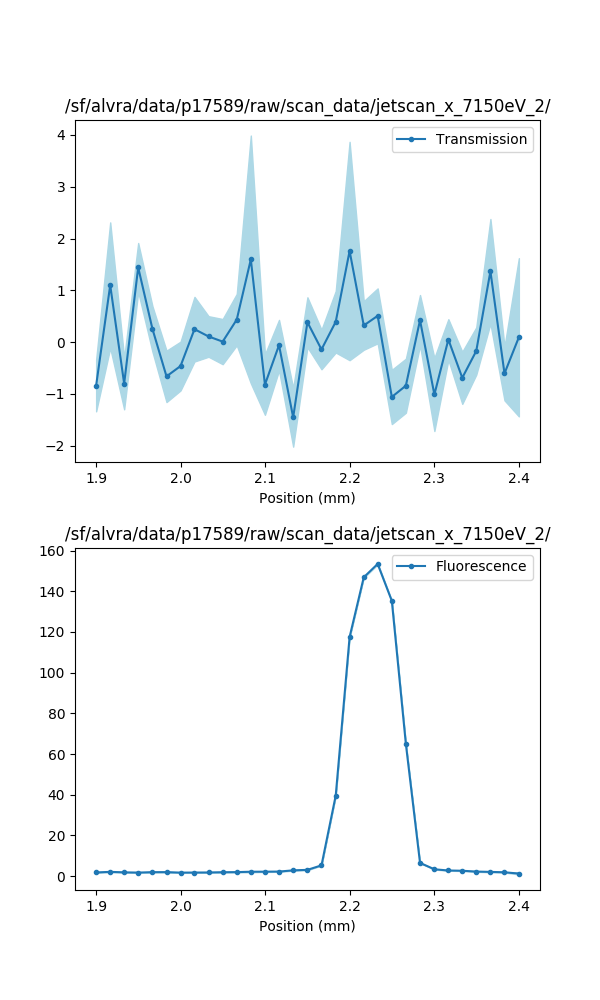

In [6]:
plt.figure(figsize = (6,10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(211)
plt.plot(Position_mm, Signal_trans, label="Transmission",marker='.')
low_err_t= Signal_trans - err_Signal_trans
high_err_t= Signal_trans + err_Signal_trans
plt.fill_between(Position_mm, low_err_t, high_err_t, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")

plt.subplot(212)
plt.plot(Position_mm, Signal_fluo, label="Fluorescence",marker='.')
low_err_f= Signal_fluo - err_Signal_fluo
high_err_f= Signal_fluo + err_Signal_fluo
plt.fill_between(Position_mm, low_err_f, high_err_f, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")

plt.show()
#plt.savefig('Timescan_7_diode')